# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('stopwords')

import seaborn as sns
from matplotlib.pylab import plt
import time
import datetime
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Configurations

In [2]:
fake_data = pd.read_csv(r"C:/Users/akash/Downloads/News-_dataset/Fake.csv")
true_data = pd.read_csv(r"C:/Users/akash/Downloads/News-_dataset/True.csv")

In [3]:
true_data['label'] = ['True']*len(true_data)
fake_data['label'] = ['Fake']*len(fake_data)

news_data = true_data.append(fake_data).sample(frac = 1).reset_index().drop(columns=['index'])

print(news_data.shape)
news_data.head()

(44898, 5)


C:\Users\akash\AppData\Local\Temp\ipykernel_8928\3795389126.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  news_data = true_data.append(fake_data).sample(frac = 1).reset_index().drop(columns=['index'])


,title,text,subject,date,label
0,"Trump, Malaysian PM discuss trade deals, Boein...",WASHINGTON (Reuters) - U.S. President Donald T...,worldnews,"September 12, 2017",True
1,Trump and spy chief differ on what was said in...,WASHINGTON (Reuters) - U.S. spy chief James Cl...,politicsNews,"January 12, 2017",True
2,Court orders Trump administration to give immi...,WASHINGTON (Reuters) - A U.S. District Court j...,politicsNews,"December 19, 2017",True
3,New Poll Shows How Batsh** CRAZY Trump Fans A...,The supporters of President-elect Donald Trump...,News,"December 9, 2016",Fake
4,Macron's Europe speech draws mixed reaction in...,BERLIN (Reuters) - French President Emmanuel M...,worldnews,"September 26, 2017",True


In [4]:
news_data.loc[news_data["label"] == "Fake", "label"] = 0
news_data.loc[news_data["label"] == "True", "label"] = 1

In [5]:
news_data

,title,text,subject,date,label
0,"Trump, Malaysian PM discuss trade deals, Boein...",WASHINGTON (Reuters) - U.S. President Donald T...,worldnews,"September 12, 2017",1
1,Trump and spy chief differ on what was said in...,WASHINGTON (Reuters) - U.S. spy chief James Cl...,politicsNews,"January 12, 2017",1
2,Court orders Trump administration to give immi...,WASHINGTON (Reuters) - A U.S. District Court j...,politicsNews,"December 19, 2017",1
3,New Poll Shows How Batsh** CRAZY Trump Fans A...,The supporters of President-elect Donald Trump...,News,"December 9, 2016",0
4,Macron's Europe speech draws mixed reaction in...,BERLIN (Reuters) - French President Emmanuel M...,worldnews,"September 26, 2017",1
...,...,...,...,...,...
44893,BIG MISTAKE! HILLARY JUST Proved To America Sh...,Dividing America will be Obama s legacy. Hilla...,left-news,"Sep 21, 2016",0
44894,Hong Kong's vanishing archives and the battle ...,HONG KONG (Reuters) - For anyone digging into ...,worldnews,"September 6, 2017",1
44895,"Trump, Bill Clinton trade insults in unusual e...",WASHINGTON (Reuters) - Donald Trump pounced on...,politicsNews,"December 20, 2016",1
44896,Truck attack suspect's New Jersey city a haven...,"PATERSON, N.J. (Reuters) - With its enormous M...",politicsNews,"November 2, 2017",1


In [6]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


In [7]:
news_data.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [8]:
news_data = news_data.fillna('')

In [9]:
news_data.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [10]:
news_data.nunique()

title      38729
text       38646
subject        8
date        2397
label          2
dtype: int64

Text(0.5, 1.0, 'Target Count')

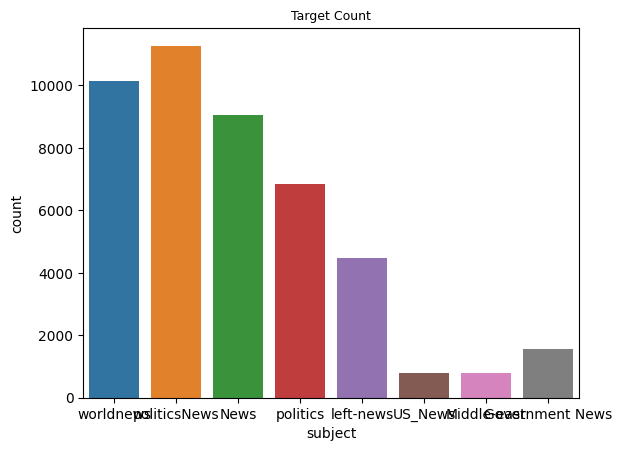

In [11]:
sns.countplot(x='subject',data=news_data)
plt.title('Target Count', fontsize=9)

# 3. Building Dataset

### Stemming & Extracting text data using TF-IDF

In [12]:
port = PorterStemmer()

def stemming(text):
    stem_text = re.sub('[^a-zA-Z0-9]', ' ', text)
    stem_text = stem_text.lower()
    stem_text = stem_text.split()
    
    stem_text = [port.stem(word) for word in stem_text if not word in stopwords.words('english')]
    stem_text = ' '.join(stem_text)
    
    return stem_text

Since there are too many text data, we extracted only important words using TF-IDF.

In [13]:
def refinement_tfidf(text): # TF-IDF
    ex = text.split('.')
    ex = pd.DataFrame(ex)[0].apply(stemming)
    
    if ex[0] == '':
        return text
    
    vectorizer = TfidfVectorizer()
    try:
        vectorizer.fit(ex)
        features = vectorizer.transform(ex)
    except:
        return text
    
    feature_names = np.array(vectorizer.get_feature_names_out())
    feature_count = features.toarray().mean(axis=0)
    
    refined_text = ' '.join(feature_names[feature_count > 0.05]) # setting the importance weights according to TF-IDF
    
    return refined_text

In [ ]:
t0 = time.time()
news_data['refined_tfidf'] = news_data['text'].apply(refinement_tfidf)
print(time.time() - t0) # It takes about 45 minutes...

In [15]:
t0 = time.time()
news_data['refined_tfidf'] = news_data['title'].apply(refinement_tfidf)
print(time.time() - t0)

177.04088735580444


In [16]:
news_data.head()

,title,text,subject,date,label,refined_tfidf
0,"Trump, Malaysian PM discuss trade deals, Boein...",WASHINGTON (Reuters) - U.S. President Donald T...,worldnews,"September 12, 2017",1,boe deal discuss jet malaysian pm trade trump
1,Trump and spy chief differ on what was said in...,WASHINGTON (Reuters) - U.S. spy chief James Cl...,politicsNews,"January 12, 2017",1,call chief differ dossier russia said spi trump
2,Court orders Trump administration to give immi...,WASHINGTON (Reuters) - A U.S. District Court j...,politicsNews,"December 19, 2017",1,abort access administr court give immigr order...
3,New Poll Shows How Batsh** CRAZY Trump Fans A...,The supporters of President-elect Donald Trump...,News,"December 9, 2016",0,batsh brutal check crazi fan give imag new pol...
4,Macron's Europe speech draws mixed reaction in...,BERLIN (Reuters) - French President Emmanuel M...,worldnews,"September 26, 2017",1,berlin draw europ macron mix reaction speech


In [17]:
labels = news_data['label'].values
texts = (news_data['refined_tfidf']).values

### Tokenization

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [19]:
idx = np.random.choice(range(len(texts)))
print(texts[idx])
# Tokenized
print(tokenizer.tokenize(texts[idx]))
# Token to Integral
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[idx])))

bid drop former gilmor governor presidenti republican virginia
['bid', 'drop', 'former', 'gil', '##mo', '##r', 'governor', 'president', '##i', 'republican', 'virginia']
[7226, 4530, 2280, 13097, 5302, 2099, 3099, 2343, 2072, 3951, 3448]


In [20]:
max_len = 0
id_len = []
for text in texts:
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    if len(input_ids) > 200:
        continue
    id_len.append(len(input_ids))
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  54


<Axes: >

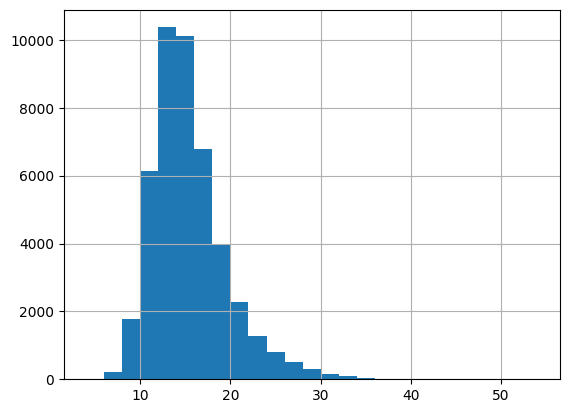

In [21]:
pd.Series(id_len).hist(bins=25)

In [22]:
def tokenize_map(sentence, labs='None'):
    global labels
    input_ids = []
    attention_masks = []
    for text in sentence:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens = True, # [CLS] & [SEP]
                            truncation = 'longest_first', # Control truncation
                            max_length = 100, # Max length about texts
                            pad_to_max_length = True, # Pad and truncate about sentences
                            return_attention_mask = True, # Attention masks
                            return_tensors = 'pt') # Return to pytorch tensors
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if labs != 'None':
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [23]:
input_ids, attention_masks, labels = tokenize_map(texts, labels)

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
len(train_dataset.indices), len(val_dataset.indices)

C:\Users\akash\.conda\envs\gpu\lib\site-packages\transformers\tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
C:\Users\akash\AppData\Local\Temp\ipykernel_8928\4287229203.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labs != 'None':


(35918, 8980)

In [24]:
batch_size = 16
num_workers = 4

train_loader = DataLoader(
                dataset=train_dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=num_workers)

val_loader = DataLoader(
                dataset=val_dataset,
                batch_size=1,
                shuffle=False)

# 4. Loading Deep Learning Model

We used BERT for natural language processing based on deep learning model.

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [26]:
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=6e-6,
                              eps=1e-8)

In [27]:
num_epochs = 1
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# 5. Training

In [28]:
model.train()

total_step = len(train_loader)
for epoch in range(num_epochs):
    total_loss = 0
    for i, (ids, masks, labels) in enumerate(train_loader):
        ids = ids.to(device)
        masks = masks.to(device)
        labels = labels.to(device)
        
        loss = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)[0]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        if (i+1) % 100 == 0:
            print('{} / {}'.format(batch_size*(i+1), train_dataset.__len__()))
            
    print('Epoch: {}, Loss: {:.4f}'.format(epoch+1, total_loss / total_step))
            
torch.save(model.state_dict(), 'BERT.h5')

1600 / 35918
3200 / 35918
4800 / 35918
6400 / 35918
8000 / 35918
9600 / 35918
11200 / 35918
12800 / 35918
14400 / 35918
16000 / 35918
17600 / 35918
19200 / 35918
20800 / 35918
22400 / 35918
24000 / 35918
25600 / 35918
27200 / 35918
28800 / 35918
30400 / 35918
32000 / 35918
33600 / 35918
35200 / 35918
Epoch: 1, Loss: 0.2333


# 6. Evaluation

In [29]:
model.eval()
model.load_state_dict(torch.load('BERT.h5', map_location=device))

<All keys matched successfully>

In [30]:
score = 0
for i, (ids, masks, labels) in enumerate(val_loader):
    ids = ids.to(device)
    masks = masks.to(device)
    labels = labels.to(device)

    g_labels = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)[1]
    
    pred = torch.max(g_labels, 1)[1][0].item()
    gt = labels[0].item()
    
    score += int(pred == gt)

avg = score / len(val_dataset)
print('Accuracy: {:.4f}\n'.format(avg))

Accuracy: 0.9359



It showed 93.59% performance!

# 7. Run Demo